In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Data_Loader import sort_data
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from Data_Loader import load_data
from Train import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader
dtype = torch.FloatTensor


In [2]:
from Data_extraction_lung import data_norm_df_lung, output_df_lung

data_norm_df_lung= data_norm_df_lung.reset_index(drop=True)
output_df_lung = output_df_lung.reset_index(drop=True)

In [3]:
data = pd.concat([data_norm_df_lung,output_df_lung], axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler
x, ytime, yevent, age = sort_data(data)
x = StandardScaler().fit_transform(x)
pca = PCA(100)
pca.fit(x)
x = pca.transform(x)

In [5]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.001, l1_ratio = 0.5)
x_df=pd.DataFrame(x, columns = np.arange(len(x[0,:])))
data_cph = pd.concat([x_df,pd.DataFrame({'age': age[:,0]/365, 'yevent': yevent[:,0], 'ytime': ytime[:,0]})], axis=1)

In [6]:
cph.fit(data_cph, duration_col = 'ytime', event_col = 'yevent')


<lifelines.CoxPHFitter: fitted with 555 total observations, 332 right-censored observations>

In [7]:
data_cph['age'].head()

0    60.279452
1    59.813699
2    62.117808
3    57.347945
4    74.180822
Name: age, dtype: float64

<Figure size 360x720 with 0 Axes>

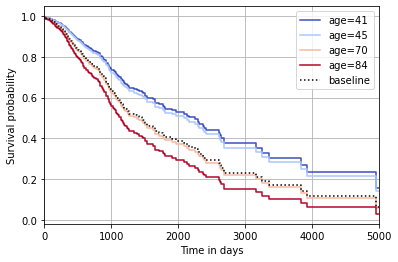

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,10))
cph.plot_partial_effects_on_outcome(covariates = 'age', values = [41, 45, 70, 84], cmap = 'coolwarm')
plt.xlim((0,5000))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [47]:
from sklearn.model_selection import KFold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
c_index_cph = []
for fold,(train_idx,test_idx) in enumerate(kfold.split(data_cph)):
    cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.1)
    data_train = data_cph.loc[train_idx].reset_index( drop = True )
    data_test  = data_cph.loc[test_idx].reset_index( drop = True )

    # Creating the X, T and E input
    X_train, X_test = data_train.drop(['ytime','yevent'], axis=1).values, data_test.drop(['ytime','yevent'], axis=1).values
    T_train, T_test = data_train['ytime'].values, data_test['ytime'].values
    E_train, E_test = data_train['yevent'].values, data_test['yevent'].values

    cph.fit(data_train, duration_col = 'ytime', event_col = 'yevent')
    Estimate = cph.predict_partial_hazard(X_test)
    E_test2= [bool(k) for k in E_test]
    c_index_cph.append(concordance_index_censored(E_test2, T_test,Estimate))

In [48]:
print([c_index_cph[k][0] for k in range (5)])
print(np.sum(c_index_cph[k][0] for k in range (5))/5)
print(np.std(np.array([c_index_cph[k][0] for k in range (5)])))

[0.610204081632653, 0.49539007092198584, 0.5776101627630011, 0.512927054478301, 0.5746478873239437]
0.5541558514239769
0.04304570366676362


C:\Users\anais\AppData\Local\Temp\ipykernel_20952\1142386609.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(np.sum(c_index_cph[k][0] for k in range (5))/5)


In [19]:
summary = cph.print_summary()


c:\Users\anais\anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 444 total observations, 268 right-censored observations>
             duration col = 'ytime'
                event col = 'yevent'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 444
number of events observed = 176
   partial log-likelihood = -830.47
         time fit was run = 2022-08-16 11:28:29 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0          -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
1           0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
2           0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
3           0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
4           0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
5           0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
6          -0.03       0.97       0.02            -0.07             0.01                 0.94                 1.01
7          -0.03       0.97       0.03            -0.09             0.04                 0.92                 1.04
8          -0.02       0.98       0.01            -0.05             0.00                 0.95                 1.00
9          -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
10          0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
11          0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
12         -0.01       0.99       0.02            -0.04             0.02                 0.96                 1.02
13         -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01
14         -0.03       0.97       0.03            -0.08             0.02                 0.92                 1.02
15         -0.01       0.99       0.01            -0.04             0.02                 0.96                 1.02
16         -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
17          0.01       1.01       0.02            -0.02             0.04                 0.98                 1.04
18         -0.02       0.98       0.02            -0.05             0.02                 0.95                 1.02
19          0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
20         -0.03       0.97       0.01            -0.05             0.00                 0.95                 1.00
21          0.01       1.01       0.02            -0.03             0.05                 0.97                 1.05
22          0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
23          0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
24         -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
25         -0.04       0.96       0.03            -0.09             0.01                 0.91                 1.01
26          0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
27         -0.02       0.98       0.02            -0.05             0.01                 0.95                 1.01
28          0.02       1.02       0.01            -0.01             0.04                 0.99                 1.04
29        

In [12]:
cph.check_assumptions(data_cph, p_value_threshold = 0.05)

ValueError: Length of values (444) does not match length of index (555)